# Proof-of-concept demo

## First load data

In [20]:
from src.utils import plot2
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("images/wood.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Load model

In [21]:
from src.model.build_sam_encoder import sam_encoder_model_registry
from src.model.smm import SMM

sam_enc_checkpoint = "weights/sam_vit_b_01ec64_encoder.pth"
model_type = "vit_b_encoder"

# load SAM encoder
device = "cpu"
sam_encoder = sam_encoder_model_registry[model_type](checkpoint=sam_enc_checkpoint)

# create SMM model
smm = SMM(sam_encoder)
smm.to(device=device)

SMM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [23]:
embs = smm._forward_encoder(img)
print(embs.shape)

torch.Size([1, 256, 64, 64])


In [24]:
import torch

# Find Best Matching Unit (BMU)
def find_bmu(x, prototypes):
    distances = torch.norm(prototypes - x, dim=2)
    return torch.argmin(distances).div(prototypes.shape[1], rounding_mode="floor"), \
           torch.argmin(distances) % prototypes.shape[1]

# Neighborhood function (Gaussian over lattice)
def neighborhood(bmu, sigma, grid_size):
    xs, ys = torch.meshgrid(
        torch.arange(grid_size[0]),
        torch.arange(grid_size[1]),
        indexing="ij"
    )
    dist_sq = (xs - bmu[0])**2 + (ys - bmu[1])**2
    return torch.exp(-dist_sq / (2 * sigma**2))

# --- Step 3: Train SOM ---
def train_som(data, prototypes, n_epochs=10, lr=0.3, sigma=2.0, decay=0.95):
    history = []
    for epoch in range(n_epochs):
        idx = torch.randperm(data.shape[0])
        for i in idx:
            x = data[i]
            bmu = find_bmu(x, prototypes)
            neigh = neighborhood(bmu, sigma, prototypes.shape[:2])[..., None]
            prototypes += lr * neigh * (x - prototypes)
        history.append(prototypes.clone())
        # decay learning rate and neighborhood
        lr *= decay
        sigma *= decay
    return history

In [25]:
# --- Step 2: Initialize SOM prototypes (neurons) ---
grid_size = (6, 6)
prototypes = torch.rand(grid_size[0], grid_size[1], 256) * 2 - 0.5  # spread randomly
print(prototypes.shape)

data = embs.permute(0, 2, 3, 1).reshape(-1, embs.shape[1])  # shape: [64*64, 256]
print(data.shape)

history = train_som(data, prototypes, n_epochs=20)

torch.Size([6, 6, 256])
torch.Size([4096, 256])


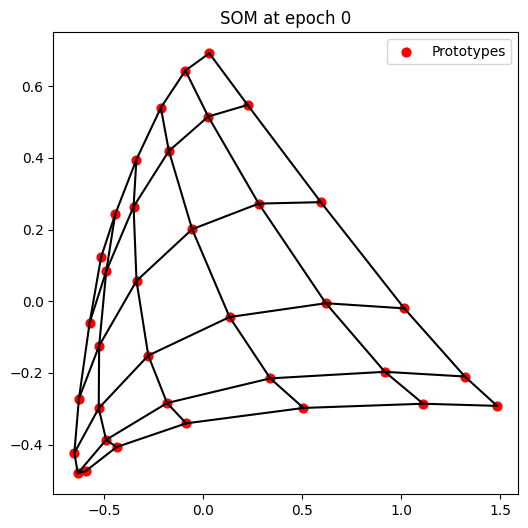

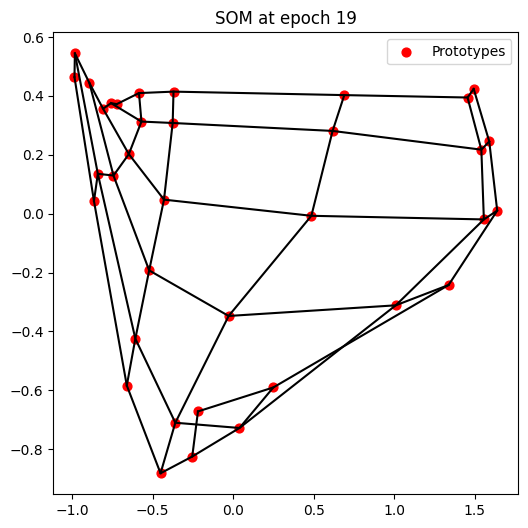

In [26]:

# --- Step 4: Visualization (2D embedding of prototypes) ---
# reduce prototypes to 2D with PCA for visualization
def pca_reduce(tensor, out_dim=2):
    X = tensor.reshape(-1, tensor.shape[-1])
    X = X - X.mean(0)
    U, S, V = torch.pca_lowrank(X, q=out_dim)
    return X @ V[:, :out_dim]

def plot_som(data, prototypes, epoch):
    proto_2d = pca_reduce(prototypes).reshape(*prototypes.shape[:2], -1)
    plt.figure(figsize=(6, 6))
    plt.scatter(proto_2d[:, :, 0].flatten().numpy(),
                proto_2d[:, :, 1].flatten().numpy(),
                c="red", s=40, label="Prototypes")
    for i in range(proto_2d.shape[0]):
        plt.plot(proto_2d[i, :, 0].numpy(), proto_2d[i, :, 1].numpy(), "k-")
    for j in range(proto_2d.shape[1]):
        plt.plot(proto_2d[:, j, 0].numpy(), proto_2d[:, j, 1].numpy(), "k-")
    plt.title(f"SOM at epoch {epoch}")
    plt.legend()
    plt.show()

plot_som(data, history[0], epoch=0)
plot_som(data, history[-1], epoch=len(history)-1)

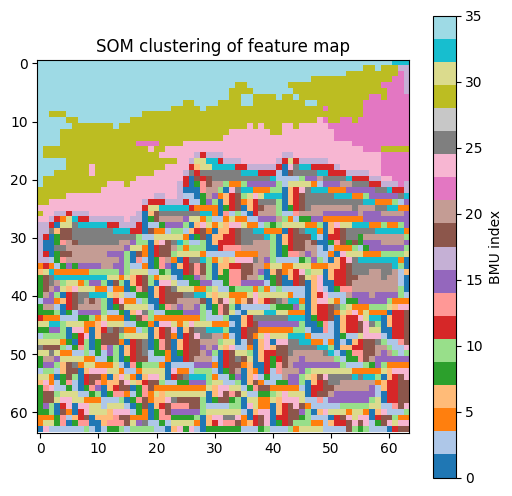

In [27]:

# --- Step 3: Assign each location to its BMU ---
def assign_bmus(data, prototypes, H, W):
    # Expand for vectorized distance computation
    P = prototypes.view(-1, prototypes.shape[-1])  # [G*G, F]
    # Compute distances [N, G*G]
    dists = torch.cdist(data, P)
    bmu_indices = torch.argmin(dists, dim=1)  # [N]
    # Reshape back to [H, W]
    return bmu_indices.view(H, W)

H, W = 64, 64
clusters = assign_bmus(data, history[-1], H, W)

# --- Step 4: Visualization ---
plt.figure(figsize=(6,6))
plt.imshow(clusters.numpy(), cmap="tab20")  # each BMU is a cluster id
plt.colorbar(label="BMU index")
plt.title("SOM clustering of feature map")
plt.show()